In [1]:
# !pip install opencv-python
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import math
from pathlib import Path
import joblib
import cv2
import statsmodels.api as sm
from scipy import stats

/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
%matplotlib inline
# increase jupyter notebook cell width
from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.container { width:90% !important; }</style>"))

def printmd(string):
    display(Markdown(string))
    
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [4]:
# Set ipython's max row display
 

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 70)
pd.set_option('display.width', 150)

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

In [5]:
# set font sizes
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.rcParams["figure.figsize"] = (20,10)

In [6]:
variety = 'hw'
df = pd.read_csv('{}_data.csv'.format(variety.upper()))
df.keys()

Index(['fruit_xmin', 'fruit_xmax', 'fruit_ymin', 'fruit_ymax', 'fruit_score', 'calyx_x', 'calyx_y', 'calyx_score', 'contour', 'aruco_ids',
       'cf_fruit_xmin', 'cf_fruit_xmax', 'cf_fruit_ymin', 'cf_fruit_ymax', 'cf_fruit_score', 'cf_calyx_x', 'cf_calyx_y', 'cf_calyx_score',
       'cf_contour', 'cf_aruco_ids', 'fruit_id', 'file', 'cf_file', 'descriptor', 'desc_dist', 'distance_to_epiline', 'disparity', 'pos_x', 'pos_y',
       'height', 'imputed_height', 'variety', 'x', 'y', 'ma', 'MA', 'angle', 'perimeter', 'coff', 'calyx_MA', 'calyx_ma', 'calyx_MA_rel',
       'calyx_ma_rel', 'area', 'maMAratio', 'occluded', 'pred_weight', 'KPIN', 'gt_weight', 'gt_volume'],
      dtype='object')

In [7]:
print(df.shape)
df.dropna(inplace=True)
df.shape

(6598, 50)


(6324, 50)

In [8]:
# check all features are present
print(df.KPIN.unique())
for f in ['x','y','height','ma','MA','maMAratio','angle','area','perimeter','coff','calyx_MA','calyx_ma','calyx_MA_rel','calyx_ma_rel']:
    if f not in df:
        print(f)

[4217 7145]


In [9]:
df.rename(columns={'gt_weight': 'cal_weight', 'aruco_ids' : 'cal_id' }, inplace=True)
df.keys()

Index(['fruit_xmin', 'fruit_xmax', 'fruit_ymin', 'fruit_ymax', 'fruit_score', 'calyx_x', 'calyx_y', 'calyx_score', 'contour', 'cal_id',
       'cf_fruit_xmin', 'cf_fruit_xmax', 'cf_fruit_ymin', 'cf_fruit_ymax', 'cf_fruit_score', 'cf_calyx_x', 'cf_calyx_y', 'cf_calyx_score',
       'cf_contour', 'cf_aruco_ids', 'fruit_id', 'file', 'cf_file', 'descriptor', 'desc_dist', 'distance_to_epiline', 'disparity', 'pos_x', 'pos_y',
       'height', 'imputed_height', 'variety', 'x', 'y', 'ma', 'MA', 'angle', 'perimeter', 'coff', 'calyx_MA', 'calyx_ma', 'calyx_MA_rel',
       'calyx_ma_rel', 'area', 'maMAratio', 'occluded', 'pred_weight', 'KPIN', 'cal_weight', 'gt_volume'],
      dtype='object')

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error

# feature_names = ['x','y','median_z','ma','MA','maMAratio','angle','area','perimeter','coff','calyx_MA','calyx_ma','calyx_MA_rel','calyx_ma_rel']
feature_names = ['x','y','height','ma','MA','maMAratio','angle','area','perimeter','coff','calyx_MA','calyx_ma','calyx_MA_rel','calyx_ma_rel']
# feature_names = ['MA', 'ma', 'coff']

nfeats = len(feature_names)
# filt = (~df.occluded) & (df.variety == variety) & (df.calyx_x > 2051 - 500 ) & (df.calyx_x < 2051 + 500 )
filt = ( (~df.occluded) & (df.variety == variety) & (df.calyx_x > 2051 - 600 ) & (df.calyx_x < 2051 + 600 )
#                                                   & (df.calyx_y > 600 - 400 ) & (df.calyx_y < 600 + 400 )
       )

# hw bays: 1001-1006, 1019-1024
# ga bays 1007 - 1018
if variety == 'hw':
    train_KPIN = [4217]
    validation_KPIN = [7145]
    aruco_id_split = 210
    bad_aruco_ids = [37]
if variety == 'ga':
    aruco_id_split = 350
    validation_KPIN = [7145]
    bad_aruco_ids = []

# train_idx = ~(df.KPIN.isin(validation_KPIN)) & filt
# val_idx = df.KPIN.isin(validation_KPIN) & filt
# # # test_idx = (df.cal_type=='unk') & filt

unique_aruco_ids = df.cal_id.unique()

# train_idx = (df.cal_id > aruco_id_split) & filt #& df.KPIN.isin(validation_KPIN)
# val_idx = (df.cal_id < aruco_id_split) & filt #& df.KPIN.isin(validation_KPIN)
# val_idx.sum(), train_idx.sum(), unique_aruco_ids.shape

train_idx = (  filt & df.KPIN.isin(train_KPIN) & ( ~df.cal_id.isin(bad_aruco_ids) ) ) 
val_idx =  (  filt & df.KPIN.isin(validation_KPIN)  & (~df.cal_id.isin(bad_aruco_ids) ) )
val_idx.sum(), train_idx.sum(), unique_aruco_ids.shape


(995, 809, (458,))

Train Set size:  809  samples,  120  features.
Val Set size:    995  samples,  120  features.


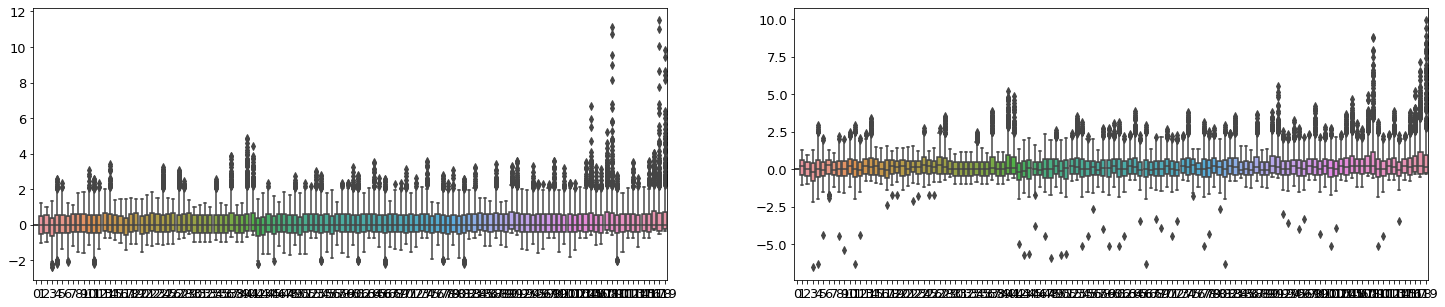

In [11]:
# scaler = StandardScaler()
scaler = RobustScaler()

poly = PolynomialFeatures(degree=2)

X_train = scaler.fit_transform(poly.fit_transform( df[feature_names][train_idx] ))
y_train = df['cal_weight'][train_idx].to_numpy()
cal_id_train = df['cal_id'][train_idx]

X_val = scaler.transform(poly.transform( df[feature_names][val_idx] ))
y_val = df['cal_weight'][val_idx].to_numpy()
cal_id_val = df['cal_id'][val_idx]

# X_test = scaler.transform(poly.transform( df[feature_names][test_idx] ))
# y_test = df['cal_weight'][test_idx].to_numpy()
# cal_id_test = df['cal_id'][test_idx]

fig1, ax1 = plt.subplots(1,2,figsize=(25,5))
sns.boxplot(data=X_train,ax=ax1[0]);
sns.boxplot(data=X_val,ax=ax1[1]);

print('Train Set size: ', X_train.shape[0], ' samples, ', X_train.shape[1], ' features.')
print('Val Set size:   ', X_val.shape[0], ' samples, ', X_val.shape[1], ' features.')
# print('Test Set size:  ', X_test.shape[0], ' samples, ', X_test.shape[1], ' features.')

In [12]:
# _ = plt.hist(df[df.KPIN==4217.].height, bins=100)
# _ = plt.hist(df[df.KPIN==7145.].height, bins=100)
# plt.show()

In [13]:
# 7145
# df[(df.height<1200) & (df.height>1150)][['height','KPIN', 'cal_id']]

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.model_selection import train_test_split
# import xgboost as xgb

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, ElasticNet, Ridge)

from sklearn.inspection import permutation_importance

hidden_layers = (int(nfeats*1))#, int(nfeats), int(nfeats), int(nfeats))#, int(nfeats/2))

# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
regressors = {
#     'Random Forest':RandomForestRegressor(max_depth=10,
#                              n_estimators=10) ,
#              'MLP': MLPRegressor(hidden_layer_sizes = hidden_layers,
#                      solver='lbfgs',activation='relu', alpha=0.1, max_iter=1000, early_stopping=True
#                                 ), 
              'Bayesian Ridge': linear_model.BayesianRidge(),
#               'XGBoost': xgb.XGBRegressor(subsample=0.25),
#               'Lasso': linear_model.Lasso(max_iter=4000),
              'OLS': LinearRegression(),
#               'Theil-Sen': TheilSenRegressor(random_state=42),
#               'RANSAC': RANSACRegressor(random_state=42),
              'HuberRegressor': HuberRegressor(alpha=0.001, max_iter=4000),
#               'ElasticNet': ElasticNet(),
              'Ridge': Ridge()
}


nreg = len(regressors)

Predicting Weight (g) with Bayesian Ridge: train r2 = 0.80, val r2 = 0.71


/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Predicting Weight (g) with OLS: train r2 = 0.85, val r2 = -2.57


/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Predicting Weight (g) with HuberRegressor: train r2 = 0.82, val r2 = 0.62


/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Predicting Weight (g) with Ridge: train r2 = 0.81, val r2 = 0.70


/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


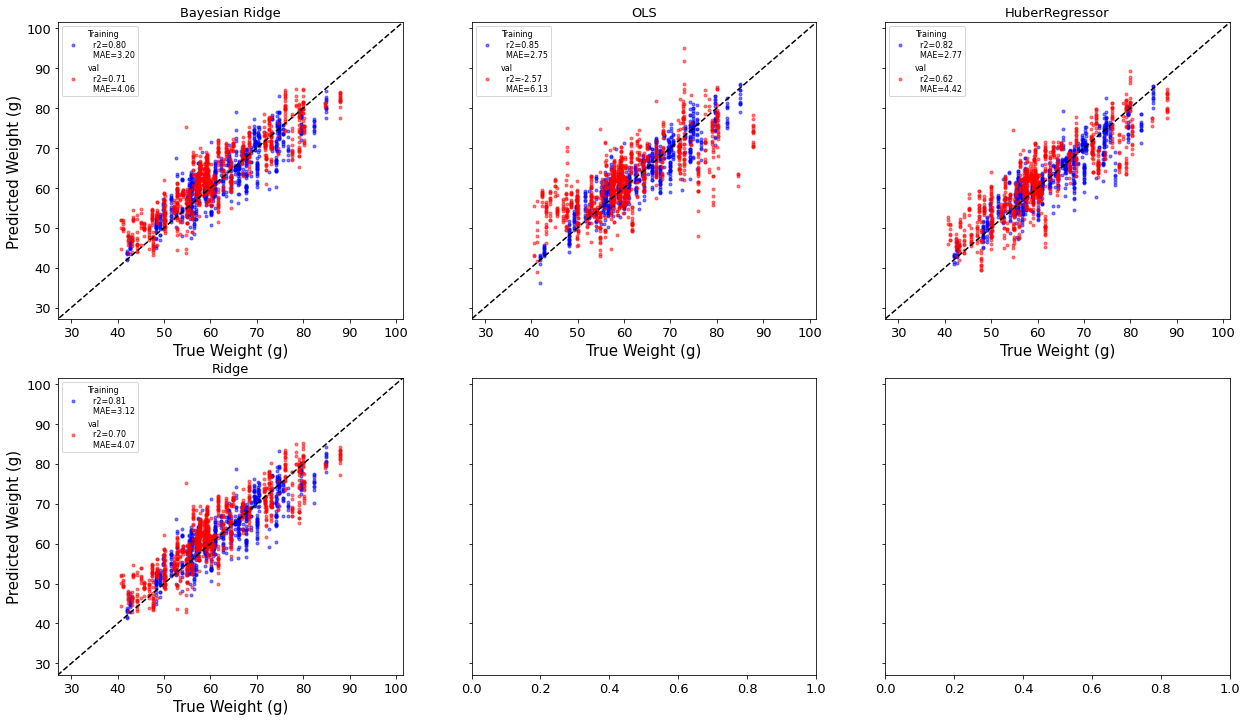

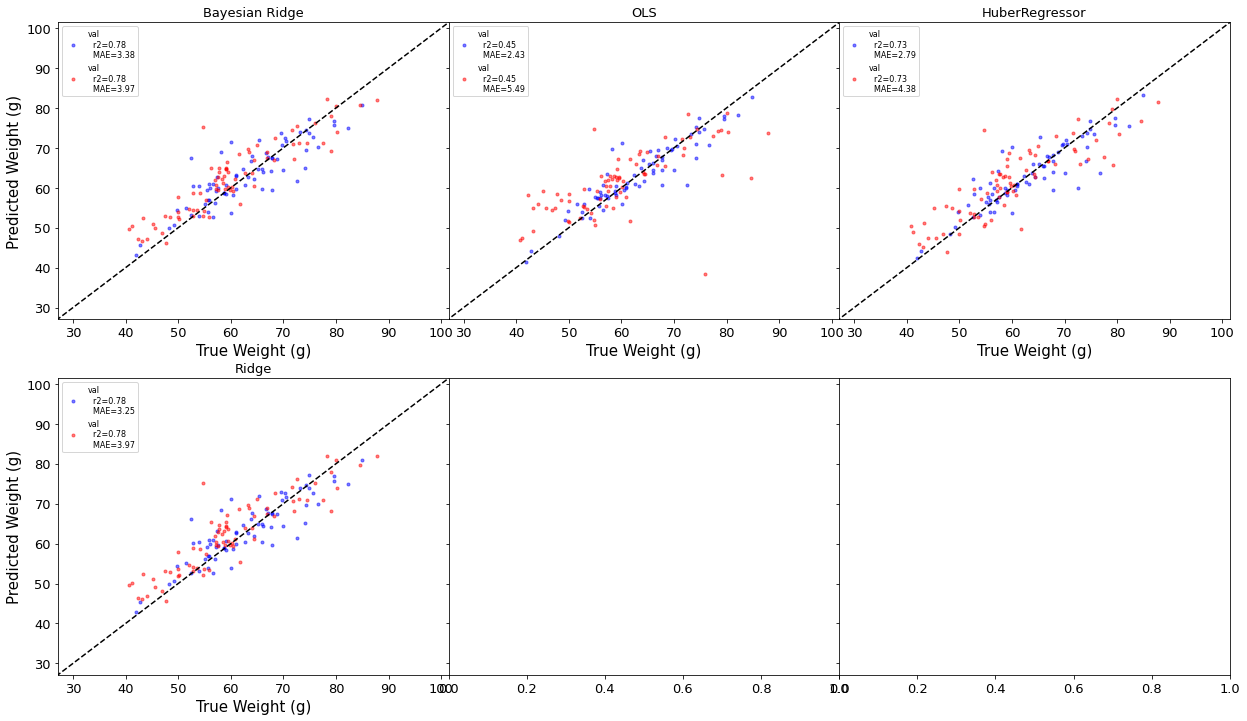

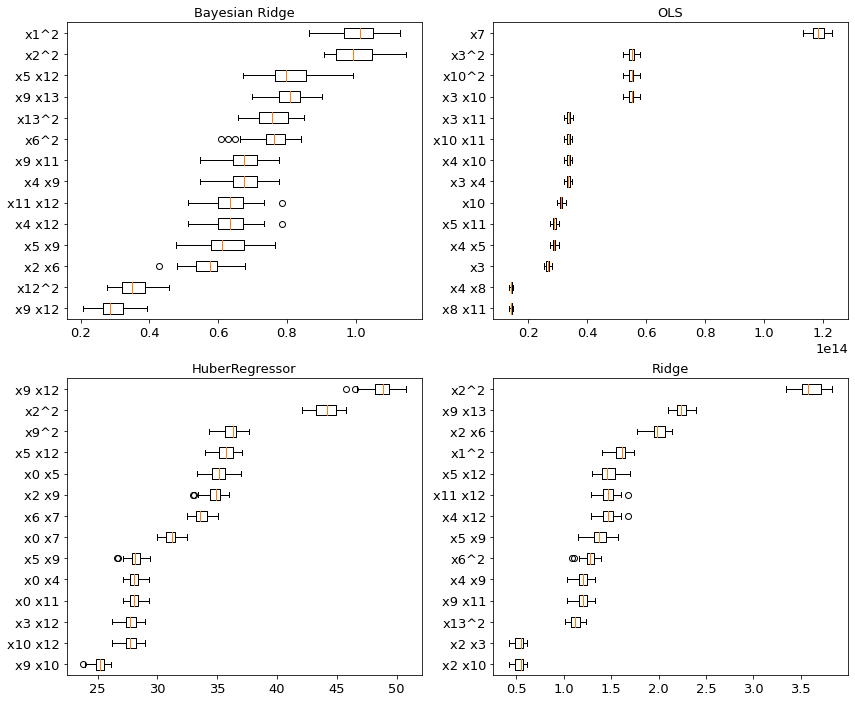

In [15]:
tname = 'Weight (g)'

# prediction vs true plots
ncols = 3
nrows = math.ceil(nreg/ncols)
fi1, axs1 = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,4*ncols), sharey=True)

# prediction vs true plots aggregated (mean) prediction
fig2, axs2 = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,4*ncols), sharey=True)

# permutation importance plots
ncols2 = 2
nrows2 = math.ceil(nreg/ncols2)
fig3, axs3 = plt.subplots(nrows=nrows2,ncols=ncols2,figsize=(7*nrows2,6*ncols2))

fig1.subplots_adjust(wspace=0)
fig2.subplots_adjust(wspace=0)
# fig2.subplots_adjust(wspace=0)

ik = 0

trained_models = {}

for reg in regressors:
    trained_models[reg] = {}
    est = regressors[reg] # estimator
    est.fit(X_train, y_train.flatten()) # training
    y_train_ = est.predict(X_train)
    y_val_ = est.predict(X_val)
    trained_models[reg]['model'] = est
    
    r2train = r2_score(y_train, y_train_)
    r2val = r2_score(y_val, y_val_)
    maetrain = mean_absolute_error(y_train, y_train_)
    maeval = mean_absolute_error(y_val, y_val_)
    trained_models[reg]['mae'] = maeval
    
    print (f'Predicting {tname} with {reg}: train r2 = {r2train:0.2f}, val r2 = {r2val:0.2f}')
    
    df_train = pd.DataFrame.from_dict({'cal_id':cal_id_train, 'weight':y_train, 'weight_':y_train_})
    df_train_grp = df_train.groupby('cal_id').mean()
    df_val = pd.DataFrame.from_dict({'cal_id':cal_id_val, 'weight':y_val, 'weight_':y_val_})
    df_val_grp = df_val.groupby('cal_id').mean()
    r2train_grp = r2_score(df_train_grp.weight, df_train_grp.weight_)
    r2val_grp = r2_score(df_val_grp.weight, df_val_grp.weight_)
    maetrain_grp = mean_absolute_error(df_train_grp.weight, df_train_grp.weight_)
    maeval_grp = mean_absolute_error(df_val_grp.weight, df_val_grp.weight_)
    
    def _format_axis(ax):
        ax.plot([0,200],[0,200],'k--')
        ax.set_xlabel(f'True {tname}')
        if ik%ncols == 0:
            ax.set_ylabel(f'Predicted {tname}')
        minyval = np.min(y_val)/3.
        ax.set_xlim([np.min(y_val)-minyval, np.max(y_val)+minyval])
        ax.set_ylim([np.min(y_val)-minyval, np.max(y_val)+minyval])
        ax.set_title(reg)
        ax.legend(loc='upper left',fontsize=8)

    ax = axs1[ik//ncols, ik%ncols]
    ax.plot(y_train, y_train_,'b.',label=f'Training\n  r2={r2train:.2f}\n  MAE={maetrain:.2f}',alpha=0.5)
    ax.plot(y_val, y_val_,'r.',label=f'val\n  r2={r2val:.2f}\n  MAE={maeval:.2f}',alpha=0.5)
    _format_axis(ax)

    ax = axs2[ik//ncols, ik%ncols]
    ax.plot(df_train_grp.weight, df_train_grp.weight_,'b.',label=f'val\n  r2={r2val_grp:.2f}\n  MAE={maetrain_grp:.2f}',alpha=0.5)
    ax.plot(df_val_grp.weight, df_val_grp.weight_,'r.',label=f'val\n  r2={r2val_grp:.2f}\n  MAE={maeval_grp:.2f}',alpha=0.5)
    _format_axis(ax)

    
    result = permutation_importance(est, X_train, y_train, n_repeats=50,
                        random_state=942,scoring='neg_mean_absolute_error')
    perm_sorted_idx = result.importances_mean.argsort()

#     sorted_list = perm_sorted_idx [-5:]

    ax = axs3[ik//ncols2, ik%ncols2]
#     ax.boxplot(result.importances[perm_sorted_idx].T, vert=False,
#     labels=np.array(feature_names)[perm_sorted_idx])
    ax.boxplot(result.importances[perm_sorted_idx[-15:-1]].T, vert=False,
    labels=np.array(poly.get_feature_names())[perm_sorted_idx[-15:-1]])
    ax.set_title(reg)

    ik += 1

In [16]:
# (df.loc[val_idx].weight-df.loc[val_idx].gt_weight).dropna()
df[df.cal_weight == np.nanmin(df[df.KPIN==4217.].cal_weight)][['KPIN','cal_id', 'height', 'file']]


,KPIN,cal_id,height,file
524,4217,585,1410.657104,Images/20220111_105703_752.jpg
531,4217,585,1400.239014,Images/20220111_105703_822.jpg
538,4217,585,1402.802368,Images/20220111_105703_892.jpg
546,4217,585,1406.197632,Images/20220111_105703_962.jpg
552,4217,585,1406.608154,Images/20220111_105704_032.jpg
559,4217,585,1411.528931,Images/20220111_105704_103.jpg
567,4217,585,1413.251343,Images/20220111_105704_173.jpg
575,4217,585,1397.945679,Images/20220111_105704_243.jpg
583,4217,585,1405.954956,Images/20220111_105704_313.jpg
591,4217,585,1392.643188,Images/20220111_105704_383.jpg


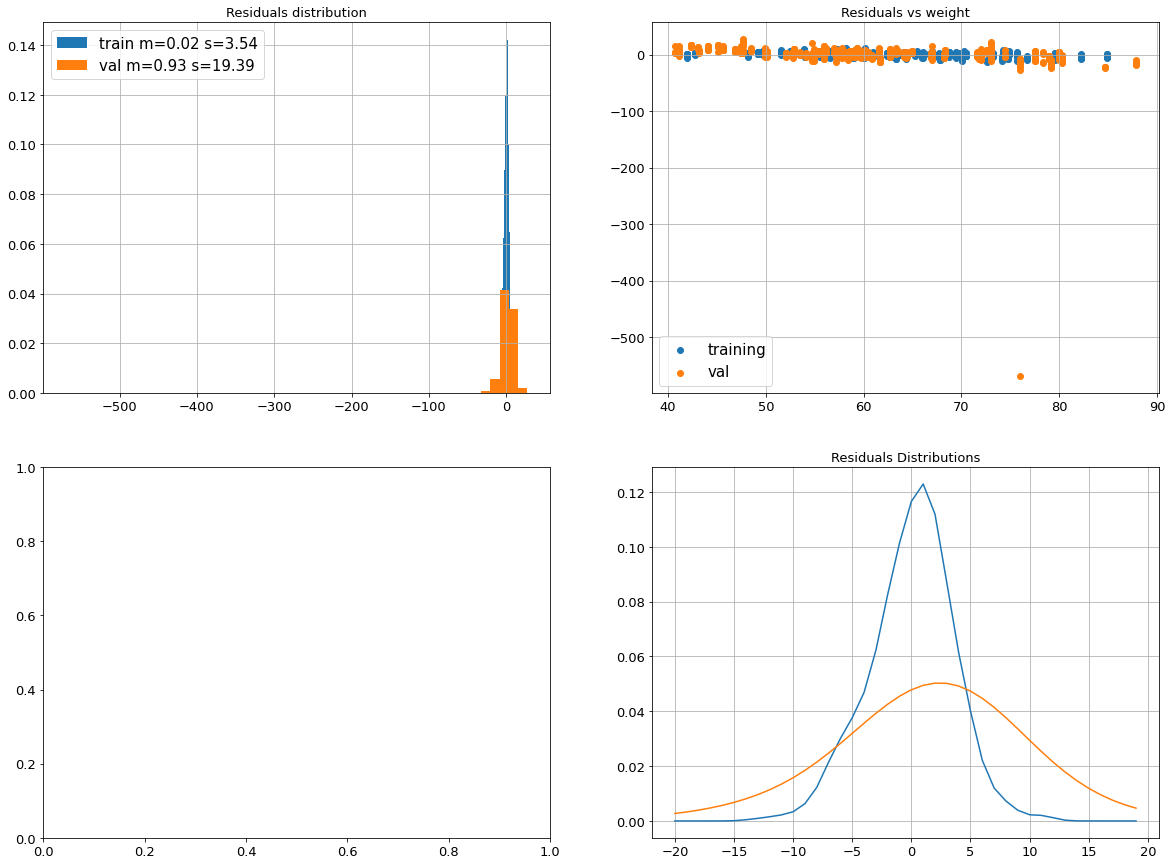

In [18]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

df['weight'] = pd.NA
# df.loc[train_idx,'weight'] = trained_models['HuberRegressor']['model'].predict(X_train)
# df.loc[val_idx,'weight'] = trained_models['HuberRegressor']['model'].predict(X_val)
df.loc[train_idx,'weight'] = trained_models['OLS']['model'].predict(X_train)
df.loc[val_idx,'weight'] = trained_models['OLS']['model'].predict(X_val)
train_res = (df.loc[train_idx].weight-df.loc[train_idx].cal_weight).dropna()
val_res = (df.loc[val_idx].weight-df.loc[val_idx].cal_weight).dropna()
ax[0,0].hist(train_res,50,density=True,label=f'train m={train_res.mean():.2f} s={train_res.std():.2f}');
ax[0,0].hist(val_res,50,density=True,label=f'val m={val_res.mean():.2f} s={val_res.std():.2f}');
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_title('Residuals distribution')

ax[0,1].scatter(df.loc[train_idx].cal_weight,df.loc[train_idx].weight-df.loc[train_idx].cal_weight,label='training')
ax[0,1].scatter(df.loc[val_idx].cal_weight,df.loc[val_idx].weight-df.loc[val_idx].cal_weight,label='val')
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].set_title('Residuals vs weight')

# sm.qqplot((df.loc[val_idx].weight-df.loc[val_idx].cal_weight),other=(df.loc[train_idx].weight-df.loc[train_idx].cal_weight),ax=ax[1,0],line='s');

kernel = stats.gaussian_kde((df.loc[train_idx].weight-df.loc[train_idx].cal_weight).to_numpy(dtype=float))
ax[1,1].plot(range(-20,20,1),kernel(range(-20,20,1)));
kernel = stats.gaussian_kde((df.loc[val_idx].weight-df.loc[val_idx].cal_weight).to_numpy(dtype=float))
ax[1,1].plot(range(-20,20,1),kernel(range(-20,20,1)));
ax[1,1].grid()
ax[1,1].set_title('Residuals Distributions');
plt.show()
# training vs validation error distribution?
# mean + std?  ,bw_method=0.27

In [ ]:
# df.loc[val_idx].weight = (df.loc[val_idx].weight - df.loc[val_idx].cal_weight)

In [ ]:
# err_df = df[['KPIN', 'weight', 'cal_weight', 'cal_id']]
# # resi = df.weight - df.cal_weight
# err_df.insert(4, 'resid', err_df.weight - err_df.cal_weight)
# err_df

In [19]:
# err_by_id = err_df.groupby(['KPIN', 'cal_id'])['resid'].mean().reset_index().dropna()

# fig, ax = plt.subplots(1,2,figsize=(18,6))
# for idx, kp in enumerate(err_by_id.KPIN.unique()):
#     ax[idx].plot(err_by_id[err_by_id.KPIN==kp].cal_id ,err_by_id[err_by_id.KPIN==kp].resid, '.', label = kp  )
#     ax[idx].legend()
#     ax[idx].set(xlabel='aruco id', ylabel = 'mean residuals')
#     ax[idx].grid()
# plt.show()

In [ ]:
# err_by_id[err_by_id.KPIN==7145].sort_values('resid', ascending=False)[:20]

In [20]:
# df[(df.KPIN==7145.) & (df.cal_id==246.0)][['cal_weight','weight', 'height']]


In [21]:
def plot_cv_res(r2s,MAEs,RMSEs):
    '''Plotting function used for cross-validation results'''
    fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(25,15))
    # plt.setp(ax, xticks=range(5), xticklabels=regressors.keys())
    ax[0,0].boxplot(r2s.T,labels=regressors.keys()); ax[0,0].set_title('r2'); ax[0,0].set_ylim([0,1])
    ax[0,1].boxplot(MAEs.T,labels=regressors.keys()); ax[0,1].set_title('MAE'); ax[0,1].set_ylim([2,8])
    ax[0,2].boxplot(RMSEs.T,labels=regressors.keys()); ax[0,2].set_title('RMSE'); ax[0,2].set_ylim([3,10])
    # plt.xticks(range(5),regressors.keys());
    lines = ax[1,0].plot(r2s); ax[1,0].set_ylim([0,1]); ax[1,0].set_xticks(range(len(regressors.keys()))); ax[1,0].set_xticklabels(regressors.keys()); ax[1,0].legend(lines,range(1,6));
    ax[1,1].plot(MAEs); ax[1,1].set_ylim([2,6]); ax[1,1].set_xticks(range(len(regressors.keys()))); ax[1,1].set_xticklabels(regressors.keys());
    ax[1,2].plot(RMSEs); ax[1,2].set_ylim([3,10]); ax[1,1].set_xticks(range(len(regressors.keys()))); ax[1,1].set_xticklabels(regressors.keys());

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, LeaveOneGroupOut, cross_val_predict
# filt = (~df.occluded) & (df.variety == variety) & (df.bay.isin([1001,1002,1003,1004,1005,1006]))
# filt = (~df.occluded) & (df.variety == variety) & (df.bay.isin([1019,1020,1021,1022,1023,1024]))

## add dummy bay feature for crossval
# 
numgrps = 5
df['bay'] =  (np.floor((np.arange(df.shape[0]))/df.shape[0]*numgrps)).astype(int)

X = df[feature_names][filt]
y = df['cal_weight'][filt].to_numpy()

Predicting weight with Bayesian Ridge: r2 = 0.74±0.06, MAE=3.68±0.42, RMSE=4.89±0.48
[0.74 0.66 0.76 0.82 0.7 ]
[4.44 3.75 3.59 3.23 3.4 ]
Predicting weight with OLS: r2 = 0.74±0.05, MAE=3.69±0.43, RMSE=4.88±0.47
[0.73 0.66 0.76 0.82 0.71]
[4.48 3.76 3.6  3.23 3.39]
Predicting weight with HuberRegressor: r2 = 0.74±0.05, MAE=3.69±0.36, RMSE=4.84±0.36
[0.75 0.66 0.76 0.81 0.73]
[4.27 3.9  3.63 3.32 3.32]
Predicting weight with Ridge: r2 = 0.74±0.05, MAE=3.66±0.36, RMSE=4.85±0.45
[0.75 0.67 0.76 0.82 0.7 ]
[4.3  3.69 3.67 3.24 3.4 ]


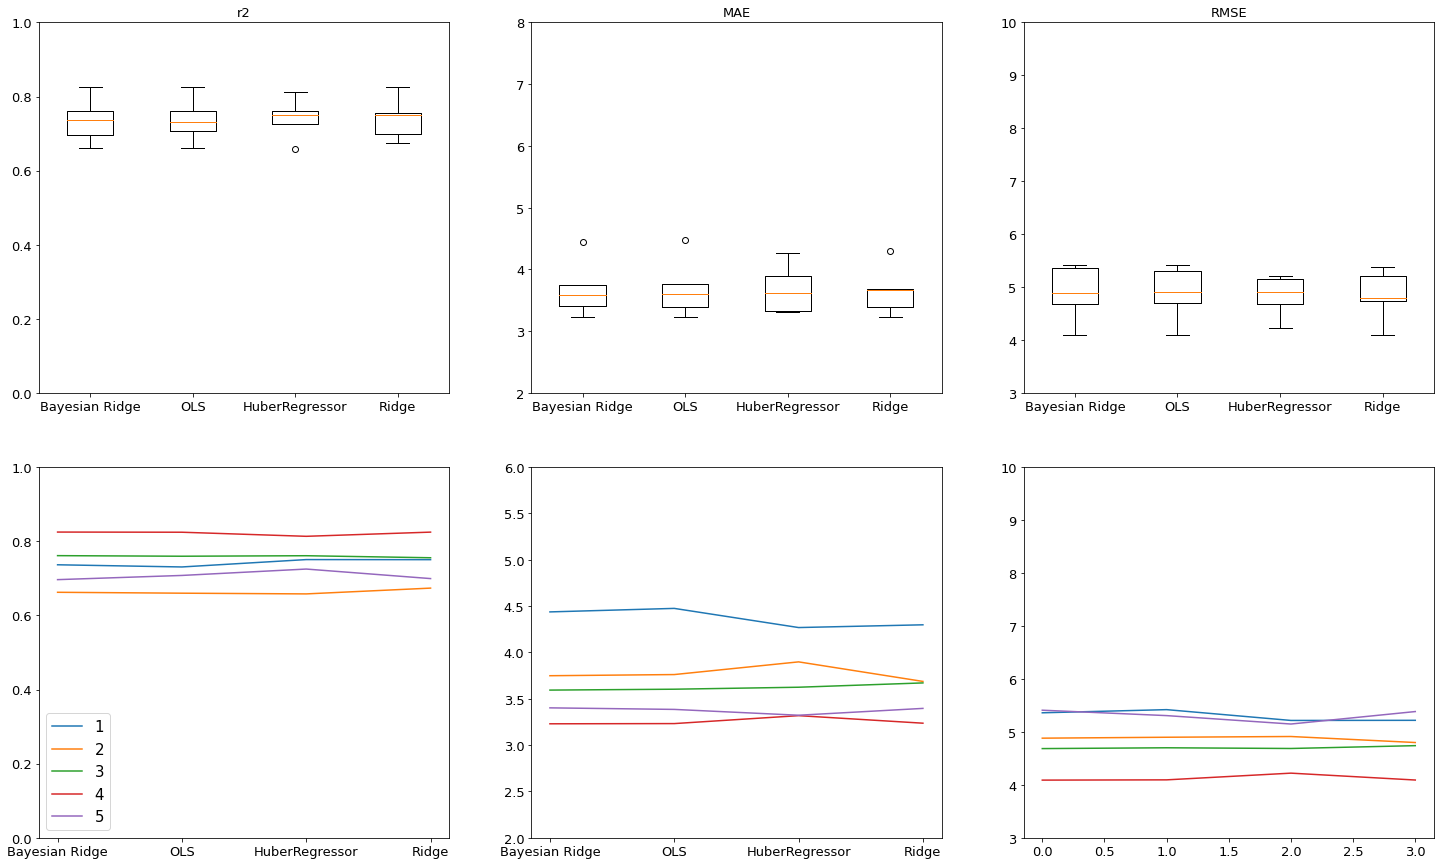

In [23]:
# Raw features
# Running cross-validation based on Bays. Have some data leakage as the same fruits are present in 2 'virtual bays' (forward and reverse passes over a bay)
# Doesn't seem to affect results much
cross_val_column = 'bay'
groups = df[cross_val_column][filt].to_numpy()

r2s = []
MAEs = []
RMSEs = []

for reg in regressors:    
    est = regressors[reg] # estimator
    pipe = Pipeline([('scaler', RobustScaler()),
                     ('estimator', est)])
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    results = cross_validate(pipe,X,y,cv=LeaveOneGroupOut(), groups=groups, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
    r2s.append(results['test_r2'])
    MAEs.append(-results['test_neg_mean_absolute_error'])
    RMSEs.append(-results['test_neg_root_mean_squared_error'])
    print(f"Predicting weight with {reg}: r2 = {results['test_r2'].mean():.2f}±{results['test_r2'].std():.2f}, MAE={-results['test_neg_mean_absolute_error'].mean():.2f}±{results['test_neg_mean_absolute_error'].std():.2f}, RMSE={-results['test_neg_root_mean_squared_error'].mean():.2f}±{results['test_neg_root_mean_squared_error'].std():.2f}")
    print(results['test_r2'])
    print(-results['test_neg_mean_absolute_error'])
r2s = np.array(r2s)
MAEs = np.array(MAEs)
RMSEs = np.array(RMSEs)
plot_cv_res(r2s,MAEs,RMSEs)

In [24]:
df['fold'] = df.bay

Predicting weight with Bayesian Ridge: r2 = 0.74±0.06, MAE=3.68±0.42, RMSE=4.89±0.48
[0.74 0.66 0.76 0.82 0.7 ]
[4.44 3.75 3.59 3.23 3.4 ]
Predicting weight with OLS: r2 = 0.74±0.05, MAE=3.69±0.43, RMSE=4.88±0.47
[0.73 0.66 0.76 0.82 0.71]
[4.48 3.76 3.6  3.23 3.39]
Predicting weight with HuberRegressor: r2 = 0.74±0.05, MAE=3.69±0.36, RMSE=4.84±0.36
[0.75 0.66 0.76 0.81 0.73]
[4.27 3.9  3.63 3.32 3.32]
Predicting weight with Ridge: r2 = 0.74±0.05, MAE=3.66±0.36, RMSE=4.85±0.45
[0.75 0.67 0.76 0.82 0.7 ]
[4.3  3.69 3.67 3.24 3.4 ]


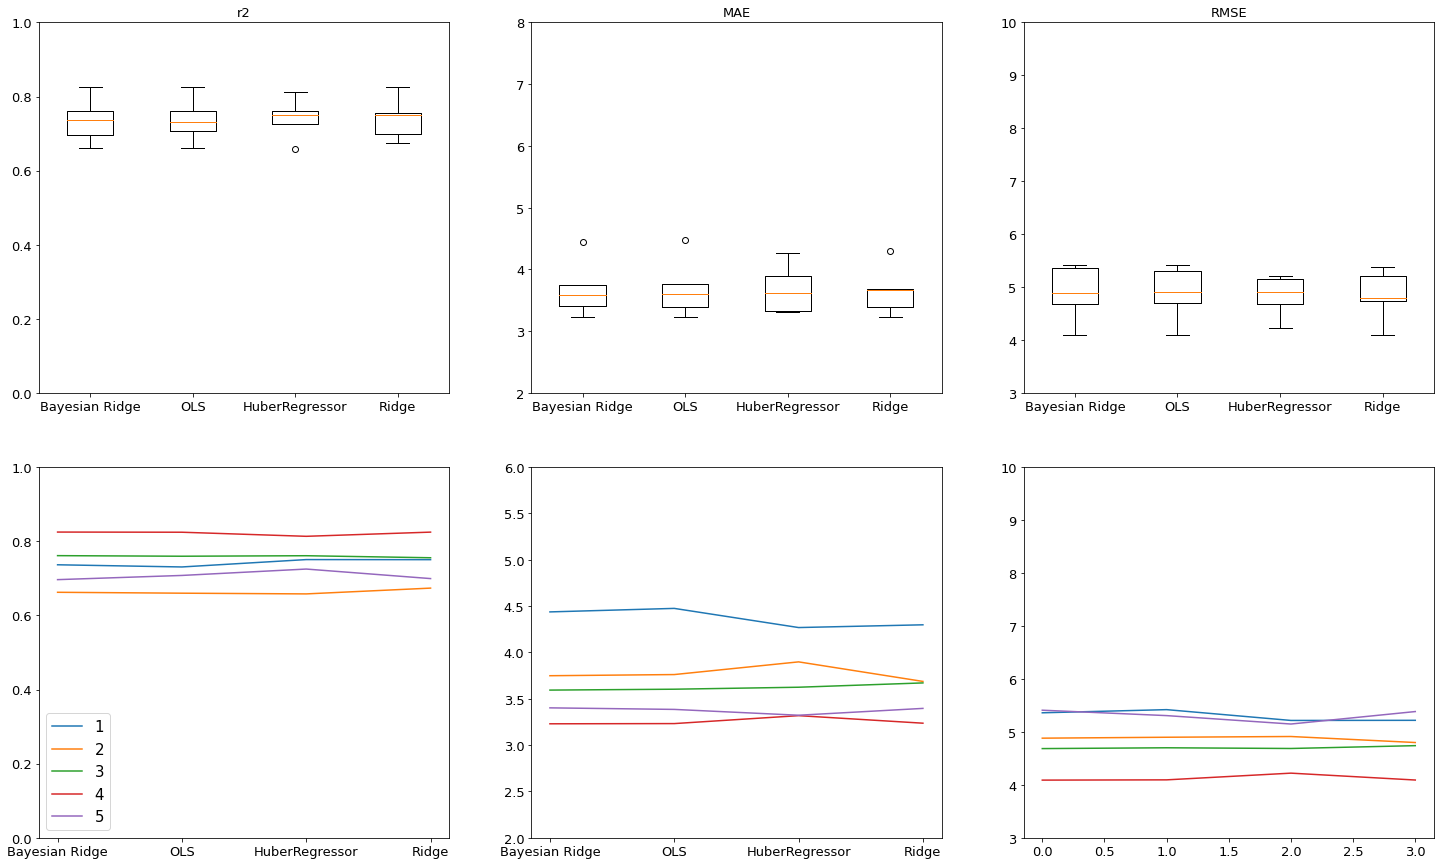

In [25]:
# Adding proper cross-validation folds with no leakage
cross_val_column = 'fold'

groups = df[cross_val_column][filt].to_numpy()


r2s = []
MAEs = []
RMSEs = []
    
for reg in regressors:    
    est = regressors[reg] # estimator
    pipe = Pipeline([('scaler', RobustScaler()),
                     ('estimator', est)])
    # https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    results = cross_validate(pipe,X,y,cv=LeaveOneGroupOut(), groups=groups, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
    r2s.append(results['test_r2'])
    MAEs.append(-results['test_neg_mean_absolute_error'])
    RMSEs.append(-results['test_neg_root_mean_squared_error'])
    print(f"Predicting weight with {reg}: r2 = {results['test_r2'].mean():.2f}±{results['test_r2'].std():.2f}, MAE={-results['test_neg_mean_absolute_error'].mean():.2f}±{results['test_neg_mean_absolute_error'].std():.2f}, RMSE={-results['test_neg_root_mean_squared_error'].mean():.2f}±{results['test_neg_root_mean_squared_error'].std():.2f}")
    print(results['test_r2'])
    print(-results['test_neg_mean_absolute_error'])
r2s = np.array(r2s)
MAEs = np.array(MAEs)
RMSEs = np.array(RMSEs)
plot_cv_res(r2s,MAEs,RMSEs)

Predicting weight with Bayesian Ridge: r2 = 0.71±0.05, MAE=3.82±0.45, RMSE=5.11±0.40
[0.71 0.65 0.7  0.79 0.7 ]
[4.6  3.79 3.97 3.44 3.33]
[5.59 4.94 5.25 4.43 5.34]
Predicting weight with OLS: r2 = -3.09±7.42, MAE=4.79±0.58, RMSE=13.26±14.73
[  0.65   0.55   0.65   0.61 -17.92]
[4.89 4.36 4.5  4.33 5.87]
[ 6.18  5.62  5.69  6.08 42.72]


/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/henrykirkwood/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converg

Predicting weight with HuberRegressor: r2 = 0.54±0.30, MAE=4.07±0.24, RMSE=6.23±1.95
[ 0.7   0.63  0.67  0.76 -0.05]
[4.47 3.99 4.18 3.76 3.93]
[ 5.7   5.14  5.48  4.76 10.08]
Predicting weight with Ridge: r2 = 0.71±0.05, MAE=3.79±0.44, RMSE=5.11±0.45
[0.72 0.66 0.71 0.8  0.68]
[4.57 3.76 3.9  3.38 3.35]
[5.55 4.92 5.14 4.36 5.59]


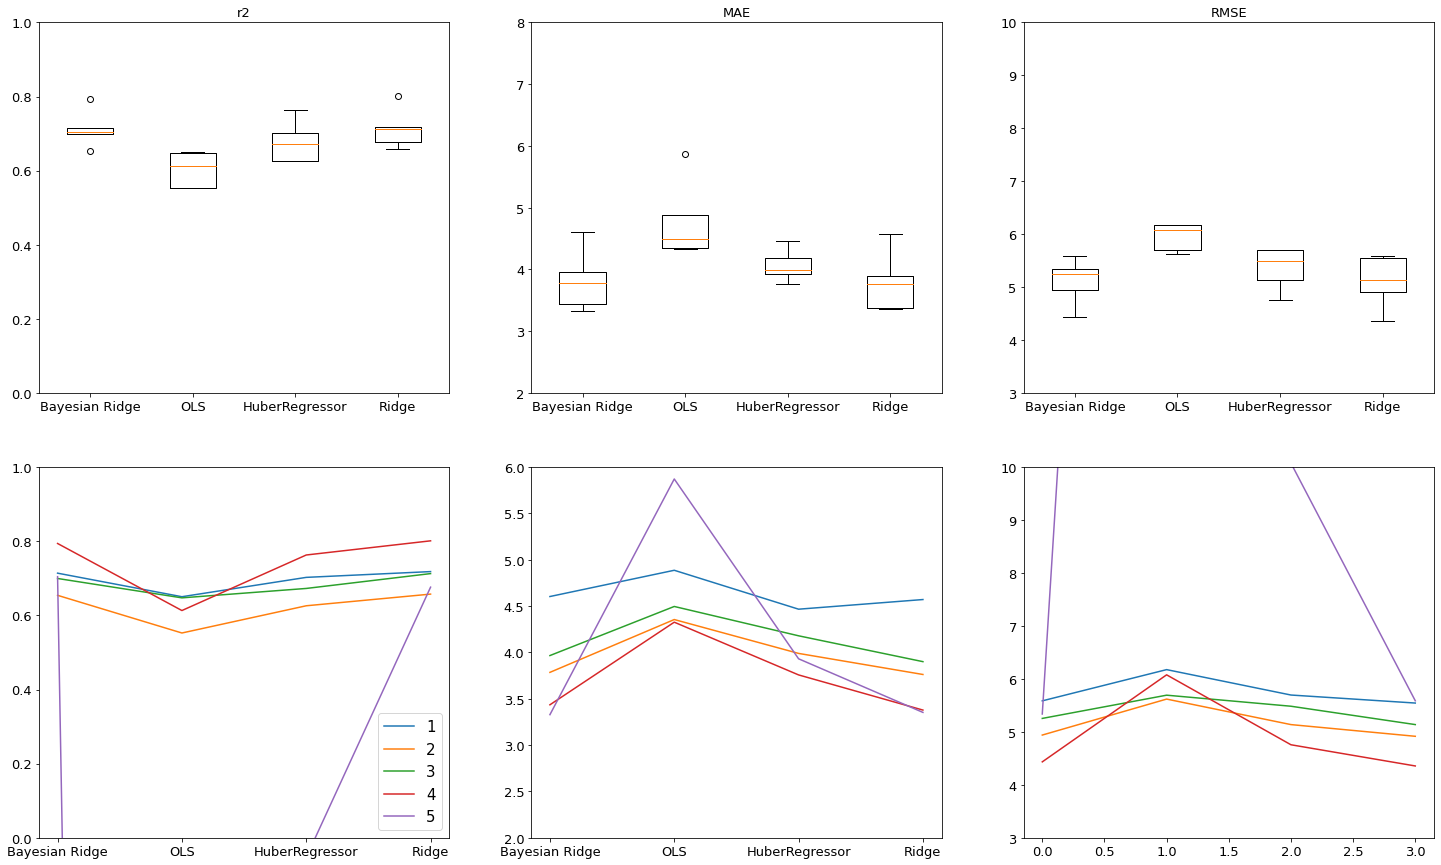

In [26]:
# Polynomial Features
# proper cross-validation with no data-leakage
cross_val_column = 'fold'
groups = df[cross_val_column][filt].to_numpy()

r2s2 = []
MAEs2 = []
RMSEs2 = []

for reg in regressors:    
    est = regressors[reg] # estimator
    pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('scaler', RobustScaler()),
                     ('estimator', est)])
    results = cross_validate(pipe,X,y,cv=LeaveOneGroupOut(), groups=groups, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
    r2s2.append(results['test_r2'])
    MAEs2.append(-results['test_neg_mean_absolute_error'])
    RMSEs2.append(-results['test_neg_root_mean_squared_error'])
    print(f"Predicting weight with {reg}: r2 = {results['test_r2'].mean():.2f}±{results['test_r2'].std():.2f}, MAE={-results['test_neg_mean_absolute_error'].mean():.2f}±{results['test_neg_mean_absolute_error'].std():.2f}, RMSE={-results['test_neg_root_mean_squared_error'].mean():.2f}±{results['test_neg_root_mean_squared_error'].std():.2f}")
    print(results['test_r2'])
    print(-results['test_neg_mean_absolute_error'])
    print(-results['test_neg_root_mean_squared_error'])
r2s2 = np.array(r2s2)
MAEs2 = np.array(MAEs2)
RMSEs2 = np.array(RMSEs2)
plot_cv_res(r2s2,MAEs2,RMSEs2)
# Predicting weight with Ridge: r2 = 0.80±0.04, MAE=4.74±0.72, RMSE=5.91±0.80

In [27]:
# r2_hw = r2s2
# MAE_hw = MAEs2
# RMSE_hw = RMSEs2

r2_ga = r2s2
MAE_ga = MAEs2
RMSE_ga = RMSEs2

<ipython-input-28-c2e4571ee8ae>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  OLS = pd.DataFrame({'variety':'ga', 'metric':'r2', 'fold':range(df.fold.unique().shape[0]),'value':r2_ga[1,:]}).append(


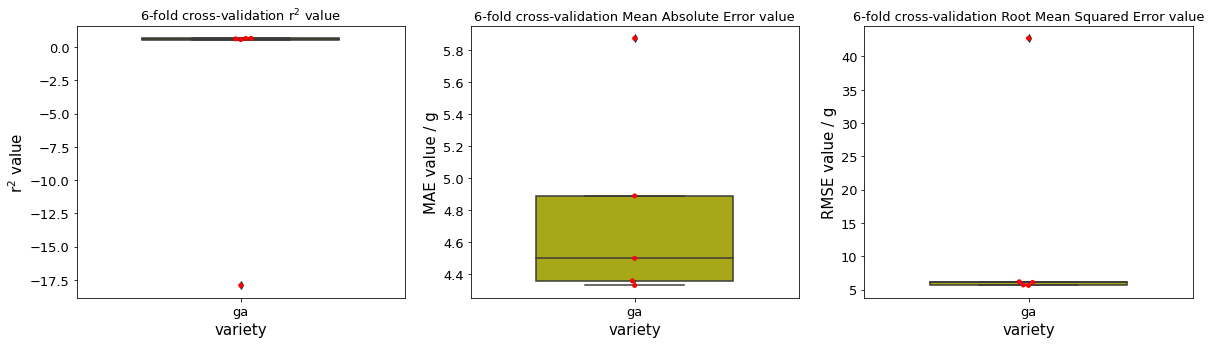

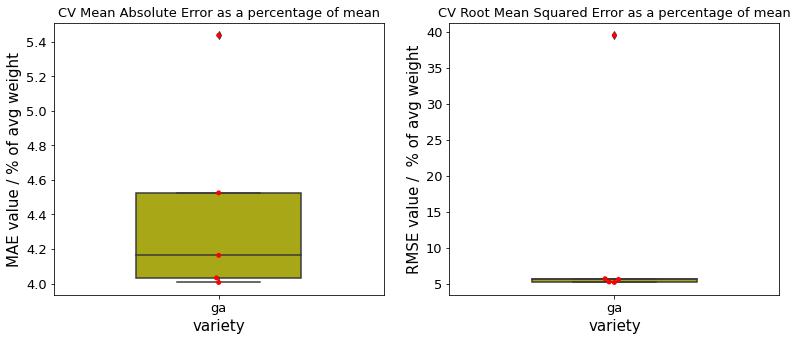

In [28]:
OLS = pd.DataFrame({'variety':'ga', 'metric':'r2', 'fold':range(df.fold.unique().shape[0]),'value':r2_ga[1,:]}).append(
    pd.DataFrame({'variety':'ga', 'metric':'MAE', 'fold':range(df.fold.unique().shape[0]),'value':MAE_ga[1,:]}),ignore_index=True).append(
    pd.DataFrame({'variety':'ga', 'metric':'RMSE', 'fold':range(df.fold.unique().shape[0]),'value':RMSE_ga[1,:]}),ignore_index=True)


fig, ax = plt.subplots(1,3,figsize=(20,5))
my_pal = {"hw": "g", "ga": "y"}

sns.boxplot(data=OLS[OLS.metric=='r2'],x='variety',y='value',ax=ax[0],width=0.6,palette=my_pal)
sns.swarmplot(data=OLS[OLS.metric=='r2'],x='variety',y='value',color='r',ax=ax[0]);
ax[0].set_ylabel('r$^2$ value');
ax[0].set_title('6-fold cross-validation r$^2$ value')

sns.boxplot(data=OLS[OLS.metric=='MAE'],x='variety',y='value',ax=ax[1],width=0.6,palette=my_pal)
sns.swarmplot(data=OLS[OLS.metric=='MAE'],x='variety',y='value',color='r',ax=ax[1]);
ax[1].set_ylabel('MAE value / g');
ax[1].set_title('6-fold cross-validation Mean Absolute Error value')

sns.boxplot(data=OLS[OLS.metric=='RMSE'],x='variety',y='value',ax=ax[2],width=0.6,palette=my_pal)
sns.swarmplot(data=OLS[OLS.metric=='RMSE'],x='variety',y='value',color='r',ax=ax[2]);
ax[2].set_ylabel('RMSE value / g');
ax[2].set_title('6-fold cross-validation Root Mean Squared Error value');

# fig.savefig('plots/cross-val_metrics.png',transparent=True, bbox_inches='tight')

mu_ga = 108
mu_hw = 67

OLS_rel = OLS.copy()  # re-calculate metrics values relative to distribution mean
OLS_rel.loc[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='hw'),'value'] = OLS_rel[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='hw')].value.apply(lambda x: x/mu_hw*100)
OLS_rel.loc[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='ga'),'value'] = OLS_rel[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='ga')].value.apply(lambda x: x/mu_ga*100)

fig, ax = plt.subplots(1,2,figsize=(13,5))


sns.boxplot(data=OLS_rel[OLS_rel.metric=='MAE'],x='variety',y='value',ax=ax[0],width=0.5,palette=my_pal)
sns.swarmplot(data=OLS_rel[OLS_rel.metric=='MAE'],x='variety',y='value',color='r',ax=ax[0]);
ax[0].set_ylabel('MAE value / % of avg weight');
ax[0].set_title('CV Mean Absolute Error as a percentage of mean')

sns.boxplot(data=OLS_rel[OLS_rel.metric=='RMSE'],x='variety',y='value',ax=ax[1],width=0.5,palette=my_pal)
sns.swarmplot(data=OLS_rel[OLS_rel.metric=='RMSE'],x='variety',y='value',color='r',ax=ax[1]);
ax[1].set_ylabel('RMSE value /  % of avg weight');
ax[1].set_title('CV Root Mean Squared Error as a percentage of mean');

# fig.savefig('plots/cross-val_metrics_relative.png',transparent=True, bbox_inches='tight')

In [ ]:
# OLS = pd.DataFrame({'variety':'hw', 'metric':'r2', 'fold':range(6), 'value':r2_hw[1,:]}).append(
#     pd.DataFrame({'variety':'ga', 'metric':'r2', 'fold':range(6),'value':r2_ga[1,:]}),ignore_index=True).append(
#     pd.DataFrame({'variety':'hw', 'metric':'MAE', 'fold':range(6),'value':MAE_hw[1,:]}),ignore_index=True).append(
#     pd.DataFrame({'variety':'ga', 'metric':'MAE', 'fold':range(6),'value':MAE_ga[1,:]}),ignore_index=True).append(
#     pd.DataFrame({'variety':'hw', 'metric':'RMSE', 'fold':range(6),'value':RMSE_hw[1,:]}),ignore_index=True).append(
#     pd.DataFrame({'variety':'ga', 'metric':'RMSE', 'fold':range(6),'value':RMSE_ga[1,:]}),ignore_index=True)


# fig, ax = plt.subplots(1,3,figsize=(20,5))
# my_pal = {"hw": "g", "ga": "y"}

# sns.boxplot(data=OLS[OLS.metric=='r2'],x='variety',y='value',ax=ax[0],width=0.6,palette=my_pal)
# sns.swarmplot(data=OLS[OLS.metric=='r2'],x='variety',y='value',color='r',ax=ax[0]);
# ax[0].set_ylabel('r$^2$ value');
# ax[0].set_title('6-fold cross-validation r$^2$ value')

# sns.boxplot(data=OLS[OLS.metric=='MAE'],x='variety',y='value',ax=ax[1],width=0.6,palette=my_pal)
# sns.swarmplot(data=OLS[OLS.metric=='MAE'],x='variety',y='value',color='r',ax=ax[1]);
# ax[1].set_ylabel('MAE value / g');
# ax[1].set_title('6-fold cross-validation Mean Absolute Error value')

# sns.boxplot(data=OLS[OLS.metric=='RMSE'],x='variety',y='value',ax=ax[2],width=0.6,palette=my_pal)
# sns.swarmplot(data=OLS[OLS.metric=='RMSE'],x='variety',y='value',color='r',ax=ax[2]);
# ax[2].set_ylabel('RMSE value / g');
# ax[2].set_title('6-fold cross-validation Root Mean Squared Error value');

# # fig.savefig('plots/cross-val_metrics.png',transparent=True, bbox_inches='tight')

# mu_ga = 108
# mu_hw = 67

# OLS_rel = OLS.copy()  # re-calculate metrics values relative to distribution mean
# OLS_rel.loc[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='hw'),'value'] = OLS_rel[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='hw')].value.apply(lambda x: x/mu_hw*100)
# OLS_rel.loc[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='ga'),'value'] = OLS_rel[OLS_rel.metric.isin(['MAE','RMSE']) & (OLS_rel.variety=='ga')].value.apply(lambda x: x/mu_ga*100)

# fig, ax = plt.subplots(1,2,figsize=(13,5))


# sns.boxplot(data=OLS_rel[OLS_rel.metric=='MAE'],x='variety',y='value',ax=ax[0],width=0.5,palette=my_pal)
# sns.swarmplot(data=OLS_rel[OLS_rel.metric=='MAE'],x='variety',y='value',color='r',ax=ax[0]);
# ax[0].set_ylabel('MAE value / % of avg weight');
# ax[0].set_title('CV Mean Absolute Error as a percentage of mean')

# sns.boxplot(data=OLS_rel[OLS_rel.metric=='RMSE'],x='variety',y='value',ax=ax[1],width=0.5,palette=my_pal)
# sns.swarmplot(data=OLS_rel[OLS_rel.metric=='RMSE'],x='variety',y='value',color='r',ax=ax[1]);
# ax[1].set_ylabel('RMSE value /  % of avg weight');
# ax[1].set_title('CV Root Mean Squared Error as a percentage of mean');

# # fig.savefig('plots/cross-val_metrics_relative.png',transparent=True, bbox_inches='tight')

In [ ]:
wrvervearvraw

In [ ]:
# Train on all data and save pipeline to file
from joblib import dump, load
est = regressors['HuberRegressor'] # estimator
# est = regressors['OLS'] # estimator
pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                 ('scaler', StandardScaler()),
                 ('estimator', est)])
pipe.fit(X,y)
# joblib.dump(pipe,'pipeline_hw2022_OLS_C.joblib')
# joblib.dump(pipe,'pipeline_ga2022_OLS_B.joblib')
y_ = pipe.predict(X)
mean_absolute_error(y_, y)

In [ ]:
# load full dataset
for i, result_path in enumerate(result_paths):
    df_ = pd.read_csv(result_path)
    if i == 0:
        df_all = df_
    else:
        df_all = df_all.append(df_,ignore_index=True)
df_all['side'] = df_all.fruit_id.map(lambda x: x.split('-')[3])
df_all.rename(columns={'pos_z':'height'},inplace=True)
df_all['bay'] = df_all.fruit_id.map(lambda x: int(x.split('-')[2])).astype('int')
print(df_all.shape)
df_all.dropna(subset=['height'], inplace=True)
print(df_all.shape)
df_all.drop(df_all[df_all.height>1300].index,inplace=True)
print(df_all.shape)
print(f"{df_all.memory_usage(deep=True).sum()/1024/1024:.1f} MB")

In [ ]:
filt_all = (~df_all.occluded) & (df_all.variety == 'hw')
df_all.loc[filt_all, 'pred_weight'] = pipe.predict(df_all.loc[filt_all, feature_names])
print(f"Check how much MAE for calibration fruit has gone up using final pipeline: {mean_absolute_error(df_all[~df_all.cal_weight.isna() & filt_all].pred_weight,df_all[~df_all.cal_weight.isna() & filt_all].cal_weight):.2f} vs training MAE {mean_absolute_error(y_,y):.2f}, where we used median_Z for some fruit.")

In [ ]:
n = df_all.loc[df_all.bay==1005].pred_weight.isna().value_counts()[False]

(pd.cut(df_all.loc[df_all.bay==1005].pred_weight,range(30,220,10)).value_counts(sort=False) / n * 1209).astype('int')


In [ ]:
pipe2020 = joblib.load('../pipeline_hw2020.joblib') # same as in app folder
y_ = pipe2020.predict(X)
MAE_pre_cal = mean_absolute_error(y,y_)
RMSE_pre_cal = np.sqrt(mean_squared_error(y,y_))
rcParams['figure.figsize'] = [9,9]
fig, axs = plt.subplots(2,2)
axs[0,0].scatter(y,y_);
axs[0,0].axis('equal')
axs[0,0].axis('square')
axs[0,0].plot([20, 110], [20, 110],'go--',linewidth=2);
axs[1,0].plot(y - y_,marker='o',linestyle='');
axs[1,0].grid()

# calib_factor = np.mean(y / y_)
calib_factor = np.mean(y) /np.mean(y_)
y_ *= calib_factor
MAE_post_cal = mean_absolute_error(y,y_)
RMSE_post_cal = np.sqrt(mean_squared_error(y,y_))

axs[0,1].scatter(y,y_);
axs[0,1].axis('equal')
axs[0,1].axis('square')
axs[0,1].plot([20, 110], [20, 110],'go--',linewidth=2);
axs[1,1].plot(y, y_ - y,marker='o',linestyle='');
axs[1,1].grid()
print(f"Using last years model MAE = {MAE_pre_cal:.2f} and {MAE_post_cal:.2f} with constant factor calibration. RMSE = {RMSE_pre_cal:.2f} and {RMSE_post_cal:.2f} ")

In [ ]:
pipe2020 = joblib.load('../pipeline_hw2020.joblib') # same as in app folder
y_ = pipe2020.predict(X)
MAE_pre_cal = mean_absolute_error(y,y_)
RMSE_pre_cal = np.sqrt(mean_squared_error(y,y_))
rcParams['figure.figsize'] = [9,9]
fig, axs = plt.subplots(2,2)
axs[0,0].scatter(y,y_);
axs[0,0].axis('equal')
axs[0,0].axis('square')
axs[0,0].plot([20, 110], [20, 110],'go--',linewidth=2);
axs[1,0].plot(y - y_,marker='o',linestyle='');
axs[1,0].grid()

# calib_factor = np.mean(y / y_)
calib_factor = np.mean(y) /np.mean(y_)
y_ *= calib_factor
MAE_post_cal = mean_absolute_error(y,y_)
RMSE_post_cal = np.sqrt(mean_squared_error(y,y_))

axs[0,1].scatter(y,y_);
axs[0,1].axis('equal')
axs[0,1].axis('square')
axs[0,1].plot([20, 110], [20, 110],'go--',linewidth=2);
axs[1,1].plot(y, y_ - y,marker='o',linestyle='');
axs[1,1].grid()
print(f"Using last years model MAE = {MAE_pre_cal:.2f} and {MAE_post_cal:.2f} with constant factor calibration. RMSE = {RMSE_pre_cal:.2f} and {RMSE_post_cal:.2f} ")

In [ ]:
calib_factor

In [ ]:
df['pred_weight'] = pipe2020.predict(df.loc[(~df.occluded) & (df.variety == 'hw'), feature_names])+calib_factor


In [ ]:
#---------------------------

In [ ]:
df[(df.height > 2000)][['file','calyx_x', 'cf_calyx_x','height','distance_to_epiline','desc_dist','disparity','cal_id','side']]

In [ ]:
# for (cal_id, side), g in df.groupby(['cal_id','side']):
#     print(cal_id,side,len(g.calyx_x))


In [ ]:
filtered = abs(df.groupby(['cal_id','side']).max().calyx_x - df.groupby(['cal_id','side']).min().calyx_x) > 100;

In [ ]:
filtered = abs(df.groupby(['cal_id','side']).max().calyx_x - df.groupby(['cal_id','side']).min().calyx_x) > 50;
filtered[filtered].index

In [ ]:
df.drop(df[(df.height<850) | (df.height > 1500)].index,inplace=True)

In [ ]:
(df.groupby('cal_id').height.max() - df.groupby('cal_id').height.min()) > 100

In [ ]:
for cal_id, g in df.groupby('cal_id'):
    if (g.height.max() - g.height.min()) > 50:
        print(f"{cal_id}, {(g.height.max() - g.height.min()):.1f} mm max height diff")
        print(g[['file', 'side', 'height']])

In [ ]:
df.height = df.height/10

In [ ]:
df[df.cal_id == 'ga-1009-54']

In [ ]:
df.drop('fruit_id',axis=1,inplace=True)

In [ ]:
for cal_id, g in df.groupby('cal_id'):
    if ((g.height.mad() < 25) & (g.height.mad() > 15)) :
        print(f"{cal_id}, median: {g.height.median()/10:.1f} mad: {g.height.mad()/10:.1f} iqr: {(g.height.quantile(.75)-g.height.quantile(.25))/10:.1f} mean: {g.height.mean()/10:.1f} std: {g.height.std()/10:.1f} cm ")
        print(g[['file', 'side', 'height']])
        

In [ ]:
g.shape

In [ ]:
cc = 0
d = {}
for cal_id, g in df.dropna().groupby('cal_id'):
#     if g.shape[0] != 3:
#         continue
    Q3 = g.height.quantile(.75)
    Q1 = g.height.quantile(.25)
    IQR = g.height.quantile(.75)-g.height.quantile(.25)
#     print(Q1,Q3,IQR)
#     print(g.height)
#     break
    s = 1.5
    L = Q1-s*IQR
    H = Q3+s*IQR
    outliers = ~g.height.between(L,H, inclusive=True)
    if outliers.any():
        d[outliers.value_counts()[True]] = d.get(outliers.value_counts()[True],0) + 1
        cc += 1
        if outliers.value_counts()[True] == 2:
            print(cal_id)
            for index, row in g.iterrows():
                out = f"{row['side']:7} {row['height']/10:.1f}, {outliers[index]:1}"
                if outliers[index]:
                    out += f" {L - row['height'] if L > row['height'] else row['height'] - H:.2f}"
                print(out)

            
#         g['outliers'] = outliers
#         print(g[['height','outliers']])

#     (g.height < (Q1-s*IQR)) or (g.height > (Q3+s*IQR))
#     if ( (g.height < (Q1-s*IQR)) or (g.height > (Q3+s*IQR)) ).any():
# #     if (g.query('(@Q1 - @s * @IQR) <= height <= (@Q3 + @s * @IQR)').height.any()):
#         print('cal_id')
print(f"There are {cc} calibration fruit with height outliers")
print(d)

In [ ]:
plt.hist(df.desc_dist,100);

In [ ]:
plt.hist(df.desc_dist,100); # 60

In [ ]:
plt.hist(df.desc_dist,100); # 80

In [ ]:
df[df.desc_dist > 350].shape

In [ ]:
# Computing IQR
Q1 = df['nb'].quantile(0.25)
Q3 = df['nb'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
filtered = df.query('(@Q1 - 1.5 * @IQR) <= nb <= (@Q3 + 1.5 * @IQR)')

In [ ]:
def log_transform(x):
    print(x)
    return np.log(x + 1) #np.log1p


scaler = StandardScaler()
transformer = FunctionTransformer(log_transform)
pipe = Pipeline(steps=[('scaler', scaler), ('transformer', transformer), ('regressor', your_regressor)], memory='sklearn_tmp_memory')

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html#sklearn.preprocessing.quantile_transform
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
